### Phys 629, Fall 2023, University of Mississippi


# Lecture 17, Chapter 5: Bayesian Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Jake VanderPlas: "Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: "Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: "Data Analysis: A Bayesian Tutorial"](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: "Probability Theory: The Logic of Science"](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: "Confidence Intervals vs. Bayesian intervals"](http://bayes.wustl.edu/etj/articles/confidence.pdf)
- [This great explanation of confidence levels versus credible regions on Stackexchange](https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval/2287#2287)

***Exercises required for class participation are in <font color='red'>red</font>.***

## Simple parameter estimation examples <a class="anchor" id="one"></a>

### Underlying Gaussian distribution with heteroscedastic Gaussian uncertainties <a class="anchor" id="onea"></a>

The final example we saw in the previous lecture dealt with Bayesian parameter estimation of a Gaussian distribution, for $\mu$ and $\sigma$. **But what if the values we measure $\{x_i\}$ also have a measurement uncertainty?** We're dealing with two levels of spread then:

- the underlying distribution spread, $\sigma$, and 
- the measurement uncertainties of the data, $\{e_i\}$

The measurement uncertainties further blur the underlying distribution. In fact, if the uncertainties are homoscedastic, the distribution of $\{x_i\}$ will be Gaussian, ***BUT*** **if the uncertainties are heteroscedastic the distribution of $\{x_i\}$ will be non-Gaussian!**

- The figure below shows a distribution of $10^6$ points drawn from $\mathcal{N}(0,1)$ and sampled with heteroscedastic Gaussian errors with widths, $e_i$, uniformly distributed between $0$ and $3$. 
- A linear superposition of these Gaussian distributions with widths equal to $\sqrt{1 + e_i^2}$ results in a non-Gaussian distribution. 
- The best-fit Gaussians centered on the sample median with widths equal to sample standard deviation and quartile-based $\sigma_G$ are shown for comparison.

![](https://www.astroml.org/_images/fig_distribution_gaussgauss_1.png)

We're trying to find the $\mu$ and $\sigma$ parameters of the underlying distribution. With uniform priors on each, the log-posterior pdf can be written as

$$ \ln p = \mathrm{constant} - \frac{1}{2}\sum_{i=1}^N \left( \ln(\sigma^2+e_i^2) + \frac{(x_i-\mu)^2}{(\sigma^2+e_i^2)} \right), $$

which looks identical to the log-likelihood $\ln L$ up to a constant due to the uniform priors. We can actually analytically maximize this to find the MAP (maximum a posteriori) value of $\mu_0$,

$$ \mu_0 = \frac{\sum_{i=1}^N x_i / (\sigma_0^2 + e_i^2)}{\sum_{i=1}^N 1 / (\sigma_0^2 + e_i^2)} $$

but a closed-form analytic solution for $\sigma_0$ does not exist. 

So we resort to numerical methods and just plot $\ln p$ on a grid. <font color='red'>Execute the following to produce the log-posterior pdf of parameters $\mu$ and $\sigma$ of an underlying Gaussian distribution. The dataset has $N=10$ values, drawn from $\mu=1$, $\sigma=1$, each measured with an uncertainty drawn from a uniform distribution $0<e_i<3$.</font>

In [7]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)

%run ./scripts/fig_likelihood_gaussgauss.py

AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

<Figure size 640x480 with 0 Axes>

<font color='red'>By eye, are $\mu=1$, $\sigma=1$ the MAP parameter values? If not, is this a problem? Discuss.</font>

**Key takeaways**
- The posterior pdf is not symmetric around $\mu=1$.
- In fact the $99.7\%$ credible region allows $\sigma=0$. 
- The marginal distributions of each parameter would not look Gaussian either.

### Gaussian distribution embedded in a uniform background distribution <a class="anchor" id="oneb"></a>

What if we wanted to **model the mixture of a Gauassian distribution with a uniform distribution**. When might that be useful?  Well, for example, finding new particles!! The following is from the [Atlas bulletin](https://atlas.cern/updates/feature/higgs-boson) of July 4th, 2018, showing the Higgs boson peak embdded in background noise and other particles.

![Atlas Higgs Boson Example](https://cds.cern.ch/record/2627611/files/Higgsto4l.png?subformat=icon-640)

Obviously this isn't *exactly* a Gaussian and a uniform distribution, but a line feature superimposed upon a background is the sort of thing that a physicist or astronomer might see and is pretty close to this case for a local region around the feature of interest. <font color='red'>Spend a moment discussing similar problems in your research areas that are like this.</font>

Let's assume that 
- the location parameter, $\mu$, is known (say from theory) and
- the uncertainties in $x_i$ are negligible compared to $\sigma$.

The likelihood of obtaining a single measurement, $x_i$, can be written as a probabilistic mixture of *either* the Gaussian *or* the uniform distribution. Hence, we use the **OR Rule** of probability:

$$p(x_i|A,\mu,\sigma,I) = \frac{A}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right) + \frac{1-A}{W}.$$

- Here the background probability is taken to be $0 < x < W$ and 0 otherwise.  
- The feature of interest lies between $0$ and $W$.  
- $A$ and $1-A$ are the relative strengths of the two components, which are obviously anti-correlated.  
- Note that there will be covariance between $A$ and $\sigma$. 

If we adopt a uniform prior in both $A$ and $\sigma$:

$$p(A,\sigma|I) = C, \; {\rm for} \; 0\le A<A_{\rm max} \; {\rm and} \; 0 \le \sigma \le \sigma_{\rm max},$$

then the posterior pdf is given by

$$\ln [p(A,\sigma|\{x_i\},\mu,W)] = const. + \sum_{i=1}^N \ln \left[\frac{A}{\sigma \sqrt{2\pi}} \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2} \right)  + \frac{1-A}{W} \right].$$

The example below is for $200$ data points with $A=0.5, \sigma=1, \mu=5, W=10$. Specifically, the bottom panel is a result drawn from this distribution and the top panel is the likelihood distribution derived from the data in the bottom panel.

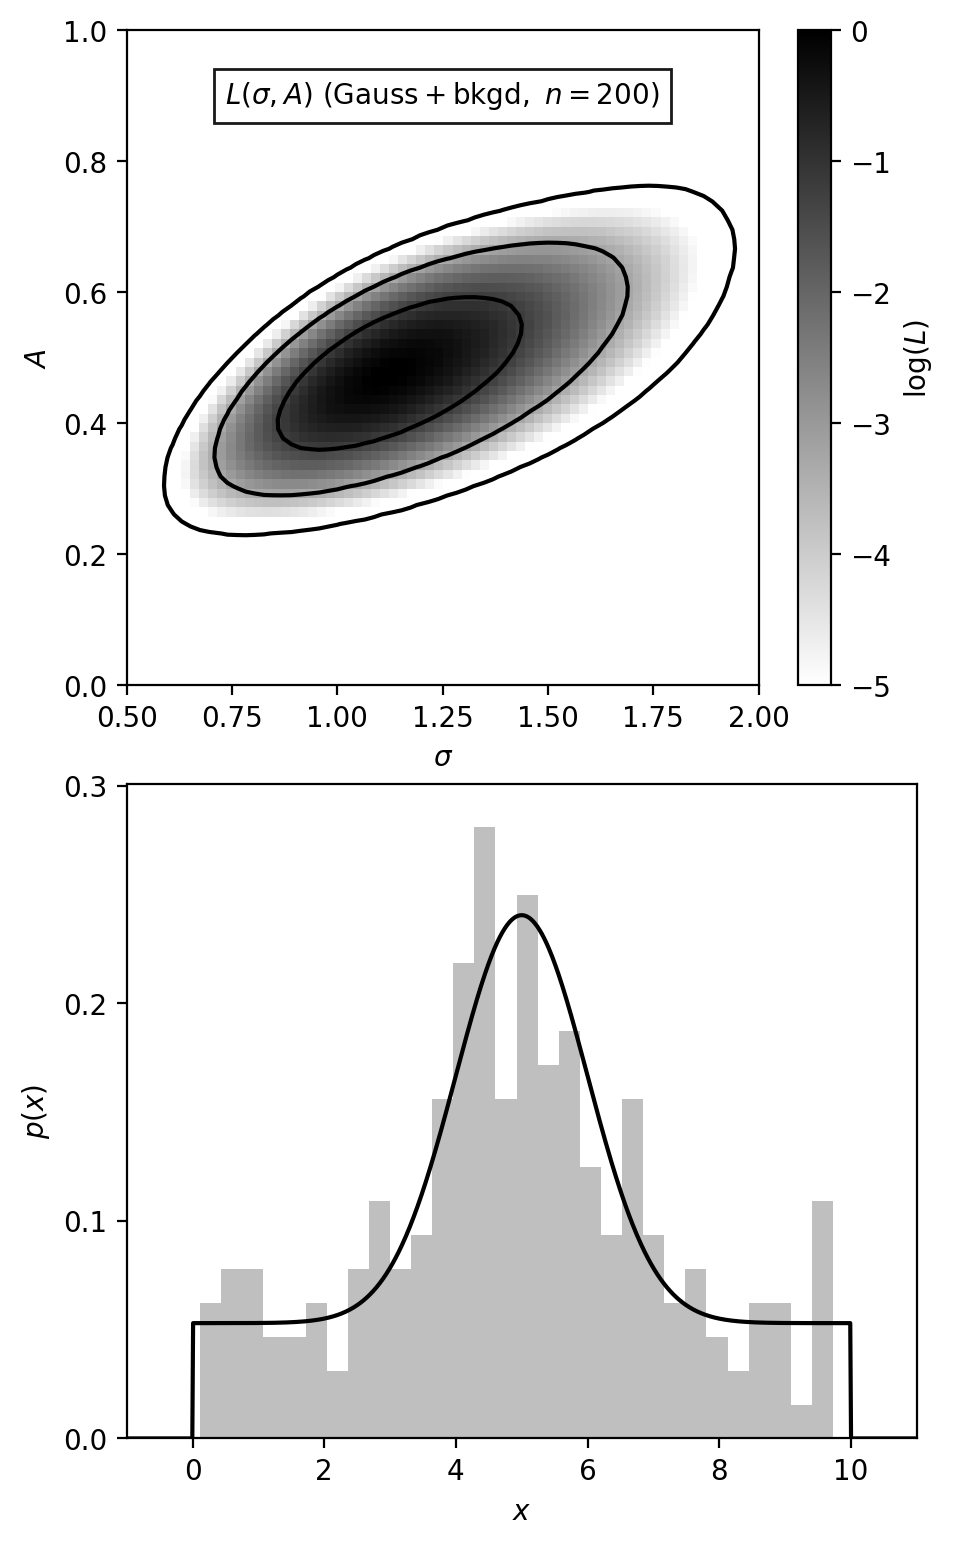

In [2]:
# %load ./scripts/fig_likelihood_gausslin.py
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import truncnorm, uniform
from astroML.plotting.mcmc import convert_to_stdev

def gausslin_logL(xi, A=0.5, sigma=1.0, mu=5.0, L=10.0):
    """Equation 5.80: gaussian likelihood with uniform background"""
    xi = np.asarray(xi)

    shape = np.broadcast(sigma, A, mu, L).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return np.sum(np.log(A * np.exp(-0.5 * ((xi - mu) / sigma) ** 2)
                         / (sigma * np.sqrt(2 * np.pi))
                         + (1. - A) / L), 0)

#------------------------------------------------------------
# Define the distribution
np.random.seed(0)
mu = 5.0
sigma = 1.0
L = 10.0
A = 0.5
N = 200

xi = np.random.random(N)
NA = np.sum(xi < A)

dist1 = truncnorm((0 - mu) / sigma, (L - mu) / sigma, mu, sigma)
dist2 = uniform(0, 10)

xi[:NA] = dist1.rvs(NA)
xi[NA:] = dist2.rvs(N - NA)

x = np.linspace(-1, 11, 1000)
fracA = NA * 1. / N

#------------------------------------------------------------
# define the (sigma, A) grid and compute logL
sigma = np.linspace(0.5, 2, 70)
A = np.linspace(0, 1, 70)

logL = gausslin_logL(xi, A[:, np.newaxis], sigma)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 8))
fig.subplots_adjust(bottom=0.07, left=0.11, hspace=0.15, top=0.95)

ax = fig.add_subplot(211)
plt.imshow(logL, origin='lower', aspect='auto',
           extent=(sigma[0], sigma[-1], A[0], A[-1]),
           cmap=plt.cm.binary)
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$A$')

ax.text(0.5, 0.9, r'$L(\sigma,A)\ (\mathrm{Gauss + bkgd},\ n=200)$',
        bbox=dict(ec='k', fc='w', alpha=0.9),
        ha='center', va='center', transform=plt.gca().transAxes)

ax.contour(sigma, A, convert_to_stdev(logL),
           levels=(0.683, 0.955, 0.997),
           colors='k')

ax2 = plt.subplot(212)
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.plot(x, fracA * dist1.pdf(x) + (1. - fracA) * dist2.pdf(x), '-k')
ax2.hist(xi, 30, density=True, histtype='stepfilled', fc='gray', alpha=0.5)

ax2.set_ylim(0, 0.301)
ax2.set_xlim(-1, 11)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$p(x)$')
plt.show()

A more realistic example might be one where all three parameters are unknown: the location, the width, and the background level. *But that will have to wait until we learn about MCMC numerical techniques.*

## Bayesian Model Comparison <a class="anchor" id="two"></a>

Model comparison and hypothesis testing in Bayesian inference are enormously different from classical/frequentist statistics. ***In Bayesian inference, we probabilistically rank models based on how well they explain the data under our prior knowledge.*** Let's look back at how we assessed goodness-of-fit and model choice in frequentist statistics. 

Let's use the example from http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
to illustrate some ideas about model selection.

<font color='red'>Execute this cell to load all of the modules we'll need and define the data array.</font>

In [3]:
from scipy import stats
from scipy import optimize

# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.25,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])

In [4]:
#Functions to do a polynomial fit, compute the likelihood, and determine the best-fit parameters.
#Nothing for you to do, just run.  (But see if you can follow what is going on.)
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

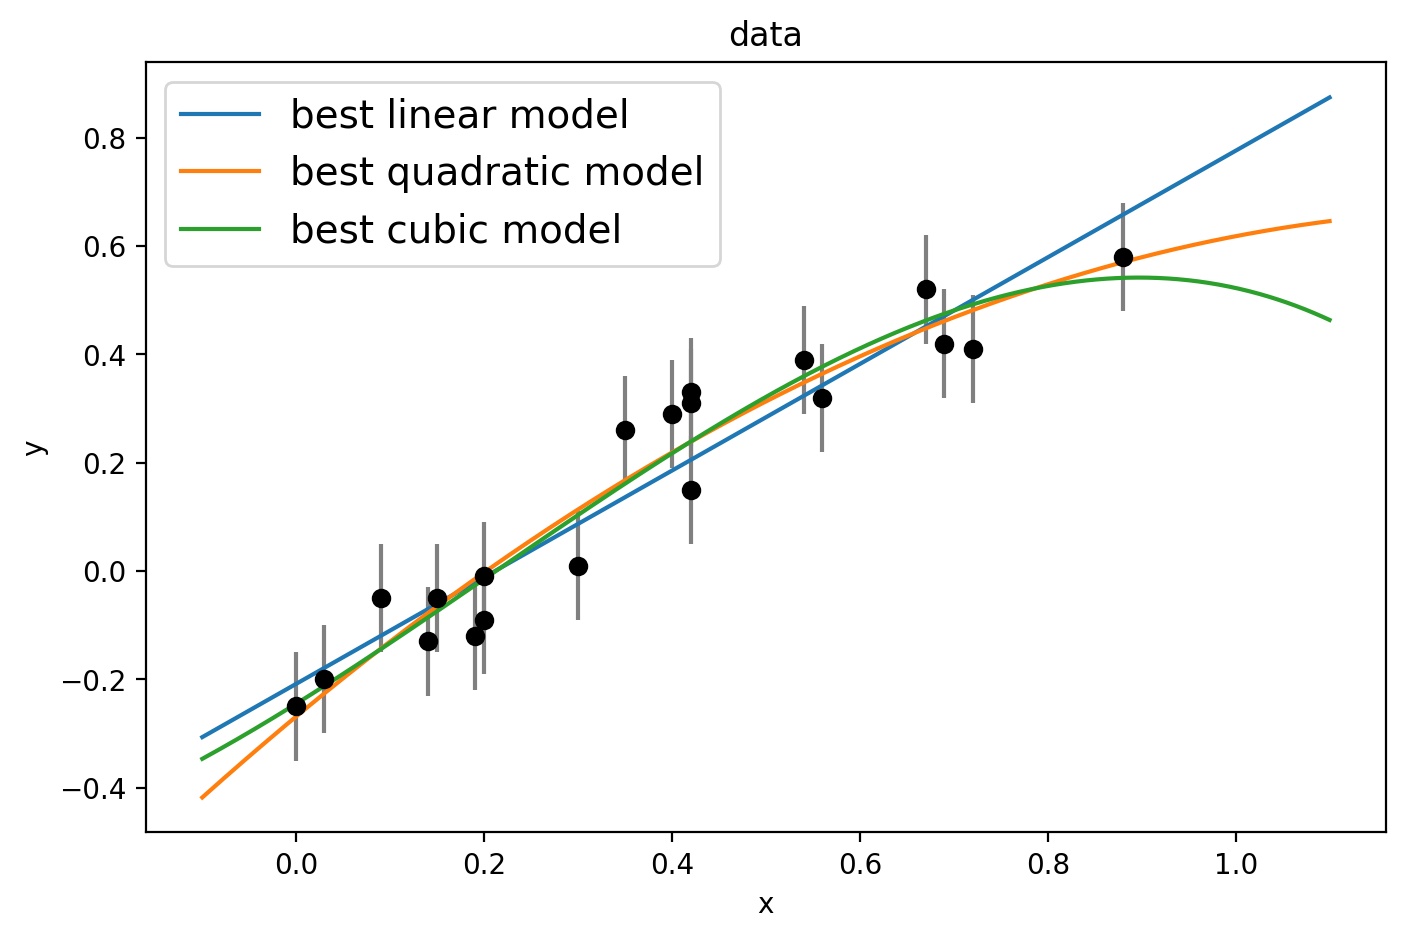

In [5]:
#Execute this cell.  See if you understand what it is doing.
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
theta3 = best_theta(3, data=data)
# generate best fit lines on a fine grid 
xgrid = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xgrid)
yfit2 = polynomial_fit(theta2, xgrid)
yfit3 = polynomial_fit(theta3, xgrid)

# plot 
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit1, label='best linear model')
ax.plot(xgrid, yfit2, label='best quadratic model')
ax.plot(xgrid, yfit3, label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

We can use $\chi^2$ per degree of freedom to determine which fit is "best".  It is computed as 

$$ \chi^2_\mathrm{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_\mathrm{fit}}{\sigma_y} \right)^2, $$

where $N$ is the number of data points and $k$ is the number of free model parameters (here 2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian with a width of
$\sigma=\sqrt{2/(N-k)}$. 

<font color='red'>Complete and execute this cell to compute $\chi^2$ and $\chi^2_\mathrm{dof}$.</font>

In [6]:
#Complete and execute this cell to compute chi2: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
# normalize by the number of degrees of freedom
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata-3)
chi2dof3 = chi23/(Ndata-4)

print("CHI2:")
print('   best linear model:', chi21)
print('best quadratic model:', chi22)
print('    best cubic model:', chi23)
print("CHI2 per degree of freedom:")
print('   best linear model:', chi2dof1)
print('best quadratic model:', chi2dof2)
print('    best cubic model:', chi2dof3)

CHI2:
   best linear model: 11.499462014956965
best quadratic model: 9.291258246116366
    best cubic model: 9.291258246116366
CHI2 per degree of freedom:
   best linear model: 0.6388590008309425
best quadratic model: 0.5465446027127274
    best cubic model: 0.5807036403822728


**Which model should we adopt?**

All $\chi^2$ values are very similar (all fit the data well equally or all overestimating the error equally).

**Occam’s razor:**
> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*

This principle was already known to [Ptolemy](https://www.wikiwand.com/en/Ptolemy) (circa 100-170 AD) who said: *“We consider it a good principle to explain the phenomena by the simplest hypothesis possible.”*

## Bayesian Model Comparison

We start with Bayes' Theorem,

$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,\times p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

and marginalize over model parameter space $\theta$
to obtain **the probability of model $M$** given the data $D$ and prior information $I$:

$$p(M\,|\,D,I) \equiv \int p(M,\theta \,|\,D,I) \, d\theta = 
      \int \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)} \, d\theta =
      \frac{p(M\,|\,I)}{p(D\,|\,I)} \int p(D\,|\,M,\theta,I)\,p(\theta\,|\,M,I) \, d\theta  $$

#### Odds Ratios \& Bayes Factors

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as

$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ (a number between 0 and 1) is

$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$

$p(D|I)$ cancels for both models.  

We get 

$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$

where $B_{21}$ is called the **Bayes factor**. 

- The Bayes factor compares how well the models fit the data. 
- It is a ratio of data likelihoods averaged over all allowed values of the model parameters. 
- If two models fit the data equally well, the "winner" is decided based on priors. 

For example, consider a noisy image of a source which is equally likely to be a star or a galaxy. 
The posterior probability that the source is a star will greatly depend on whether we are looking 
at the Galactic plane or not. 